In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
datasetUsersCSVPath  = "../dataset/users.csv"
resultDatasetPath = "../dataset/users_clean_with_outliers.h5"

In [3]:
%%time
df_users_orig = pd.read_csv(datasetUsersCSVPath, sep=',', index_col=0)
df_users = df_users_orig.copy()

CPU times: user 25.4 ms, sys: 3.39 ms, total: 28.8 ms
Wall time: 27.2 ms


In [4]:
# Make all the strings lower case and trim leading and trailing spaces
df_users = df_users.applymap(lambda x:x.lower().strip() if type(x) == str else x)
df_users = df_users.replace(r"\s{2,}", " ", regex=True)

## Name

In [44]:
len(df_users[df_users.name == "unknown"])

0

In [45]:
df_users[df_users.name.isna()]

,name,lang,bot,created_at,statuses_count
id,,,,,
2166124159,NaN,en,0,2018-11-02 06:39:14,6566.0


In [46]:
df_users.loc[df_users.name.isna(), "name"] = "unknown"

## Lang

In [6]:
uniqueLanguages = df_users.lang.unique()
print("Languages:", uniqueLanguages)
print(len(uniqueLanguages), "unique languages")
print(df_users.lang.isna().sum(), "missing languages")

Languages: ['en' 'it' 'fr' 'ru' 'es' 'tr' 'en-gb' 'pt' 'nl' 'id' 'zh-tw' 'ja' 'de'
 'ko' 'en-au' 'da' 'ar' 'select language...' 'zh-cn' 'pl' 'el' 'fil' 'sv'
 'xx-lc']
24 unique languages
0 missing languages


In [7]:
languages_count = df_users.lang.value_counts()
invalidLanguageUsers = languages_count['select language...'] + languages_count['xx-lc']
print("There are 2 invalid languages, 'Select Language...' and 'xx-lc'. There is a total of", invalidLanguageUsers, "users with invalid entries")

There are 2 invalid languages, 'Select Language...' and 'xx-lc'. There is a total of 3 users with invalid entries


In [8]:
df_users[df_users.lang == 'select language...']

,name,lang,bot,created_at,statuses_count
id,,,,,
2956613720,leanne arker,select language...,0,2020-01-05 00:09:59,57.0
2904858613,brooke,select language...,0,2019-11-22 05:44:46,85.0


In [9]:
df_users[df_users.lang == 'xx-lc']

,name,lang,bot,created_at,statuses_count
id,,,,,
29552151,chloe,xx-lc,0,2014-04-09 21:36:02,15398.0


In [11]:
# the tweets of these users are in english
df_users.loc[df_users.lang == 'select language...', "lang"] = "en"
df_users.loc[df_users.lang == 'xx-lc', "lang"] = "en"

In [15]:
df_users.loc[df_users.lang == 'en-gb', "lang"] = "en"
df_users.loc[df_users.lang == 'en-au', "lang"] = "en"
df_users.loc[df_users.lang == 'zh-cn', "lang"] = "zh"
df_users.loc[df_users.lang == 'zh-tw', "lang"] = "zh"

## Created_at

In [16]:
df_users.created_at = pd.to_datetime(df_users.created_at, format='%Y-%m-%d %H:%M:%S')
df_users.dtypes

name                      object
lang                      object
bot                        int64
created_at        datetime64[ns]
statuses_count           float64
dtype: object

## Statuses_count

In [17]:
print(df_users.statuses_count.isna().sum(), "missing statuses_count values")

399 missing statuses_count values


In [19]:
df_users[df_users.statuses_count.isna()]

,name,lang,bot,created_at,statuses_count
id,,,,,
616225564,anisha williams,en,0,2017-06-25 15:49:36,NaN
1370348599,robert brown,en,0,2018-04-23 19:05:48,NaN
617369459,sage pennington,en,0,2017-06-26 18:50:48,NaN
2362195375,delaine nock,en,0,2019-02-28 05:35:38,NaN
2351047069,tosha pacitti,en,0,2019-02-21 03:14:40,NaN
...,...,...,...,...,...
2352903248,margherita dass,en,0,2019-02-22 07:59:20,NaN
2366095543,annmarie willoby,en,0,2019-03-02 20:53:35,NaN
1176282888,blanch mobley,en,0,2018-02-15 17:38:55,NaN


In [36]:
def hist(df, column):
    numberOfBins = int(np.log2(len(df[column][df[column].notna()])) + 1)
    print("Number of bins:", numberOfBins)
    df[column].plot(kind='hist', title=column, bins=numberOfBins)
    plt.ylabel("count")
    plt.show()

def boxplot(df, column):
    df.boxplot(column=column)
    plt.show()

def log_scale(df, column):
    return pd.DataFrame(np.log10(1+df[column][df[column].notna()]))

def analyze_column(df, column):
    hist(df, column)
    
    print("\n\nLog scale")
    column_log_scale = log_scale(df, column)
    hist(column_log_scale, column)

    median = df[column].median()
    print("\n\nMedian:", median)

    return median

def fillna_grouby_botcolumn(df, attr, global_median):
    print("Missing value before: ", df[attr].isna().sum())
    df[attr].fillna(df.groupby(["bot"])[attr].transform(lambda x: np.floor(np.nanmedian(x))), inplace=True)
    df[attr].fillna(global_median, inplace=True)
    print("Missing value after: ", df[attr].isna().sum())

Number of bins: 14


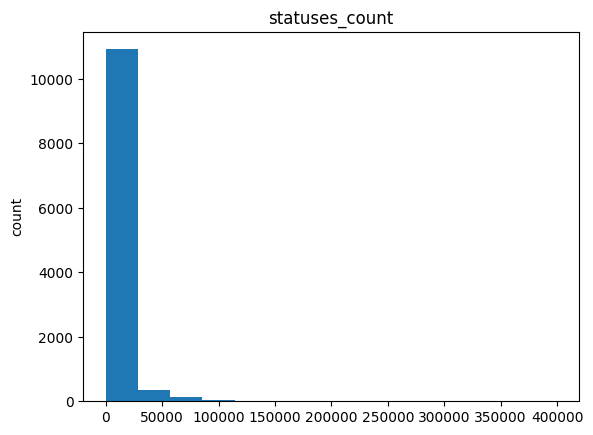



Log scale
Number of bins: 14


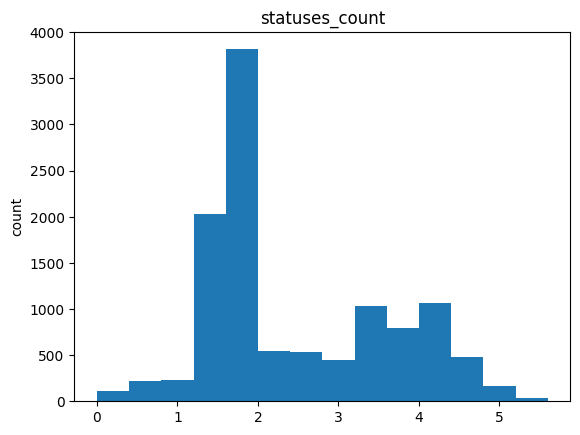



Median: 71.0


In [39]:
global_median = analyze_column(df_users, "statuses_count")

In [23]:
# split into bots and real users
real_users = df_users[df_users.bot == 0]
bots       = df_users[df_users.bot == 1]

Number of bins: 13


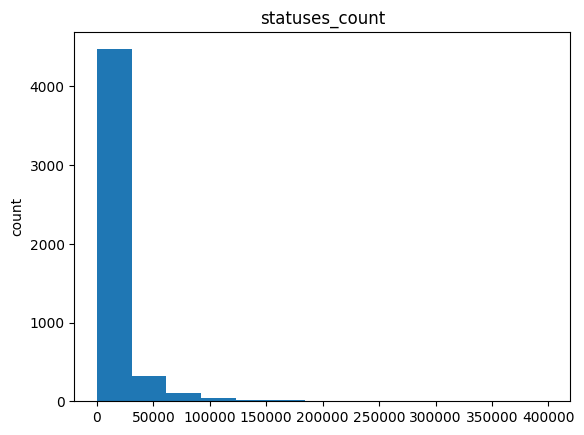



Log scale
Number of bins: 13


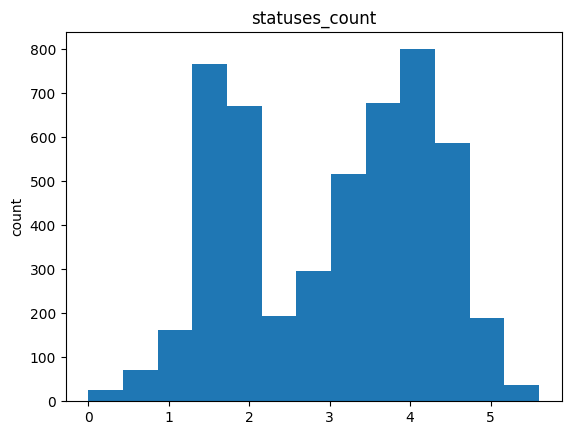



Median: 2041.0


In [26]:
median = analyze_column(real_users, "statuses_count")

### Bots

Number of bins: 13


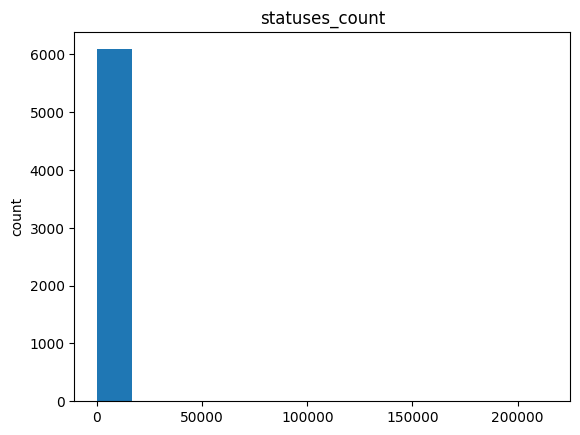



Log scale
Number of bins: 13


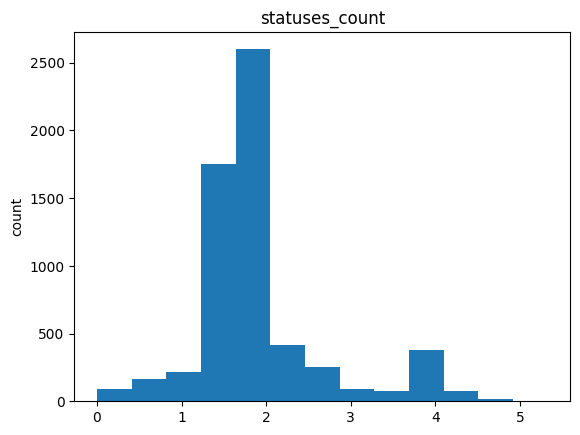



Median: 53.0


53.0

In [25]:
median = analyze_column(bots, "statuses_count")

In [ ]:
fillna_grouby_botcolumn(df_users, "statuses_count", global_median)

Missing value before:  399
Missing value after:  0


In [40]:
df_users

,name,lang,bot,created_at,statuses_count
id,,,,,
2353593986,lamonica raborn,en,1,2019-02-22 18:00:42,76.0
2358850842,lourie botton,en,0,2019-02-26 03:02:32,54.0
137959629,dadan syarifudin,en,1,2015-04-30 07:09:56,3.0
466124818,carletto focia,it,1,2017-01-18 02:49:18,50.0
2571493866,mbk ebook,en,0,2019-06-18 19:30:21,7085.0
...,...,...,...,...,...
2911861962,madrid lae maika .,en,0,2019-11-29 13:16:02,1126.0
1378532629,clau sato,en,0,2018-04-27 03:01:58,3024.0
126984069,alma leticia nuño,es,0,2015-03-29 17:01:24,6.0


In [43]:
df_users.dtypes

name                      object
lang                      object
bot                        int64
created_at        datetime64[ns]
statuses_count           float64
dtype: object

In [51]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            11508 non-null  object        
 1   lang            11508 non-null  object        
 2   bot             11508 non-null  int64         
 3   created_at      11508 non-null  datetime64[ns]
 4   statuses_count  11508 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 797.5+ KB


# Save to file

In [53]:
df_users.to_hdf(resultDatasetPath, 'df_users', mode='w')